In [1]:
# !pip install -r requirements.txt

In [2]:
# Mine
import ABC,Models,Plotting

# Helper Packages
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats

In [3]:
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Size plots
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 100

In [5]:
# This is only included so that my comments about results hold.
seed=23032020

This notebook demonstrates the Approximate Bayesian Computation (ABC) Methods which I have implemented in `ABC.py`.
 * [Set-Up](#Set-Up)
 * [ABC-Rejection Sampling](#ABC-Rejection-Sampling)
 * ["Best Samples" ABC-Rejection Sampling](#"Best-Samples"-ABC-Rejection-Sampling)
 * [ABC-MCMC](#ABC-MCMC)
 * [ABC-SMC](#ABC-SMC)
 * [Adaptive ABC-SMC](#Adaptive-ABC-SMC)

# Set-Up
### Model
I will demonstrate each ABC method on an SIR model for a population of 100,000 with 100 initial infectees and parameters $\beta=1$ and $\gamma=0.5$. This is the model used in my report and defined below.

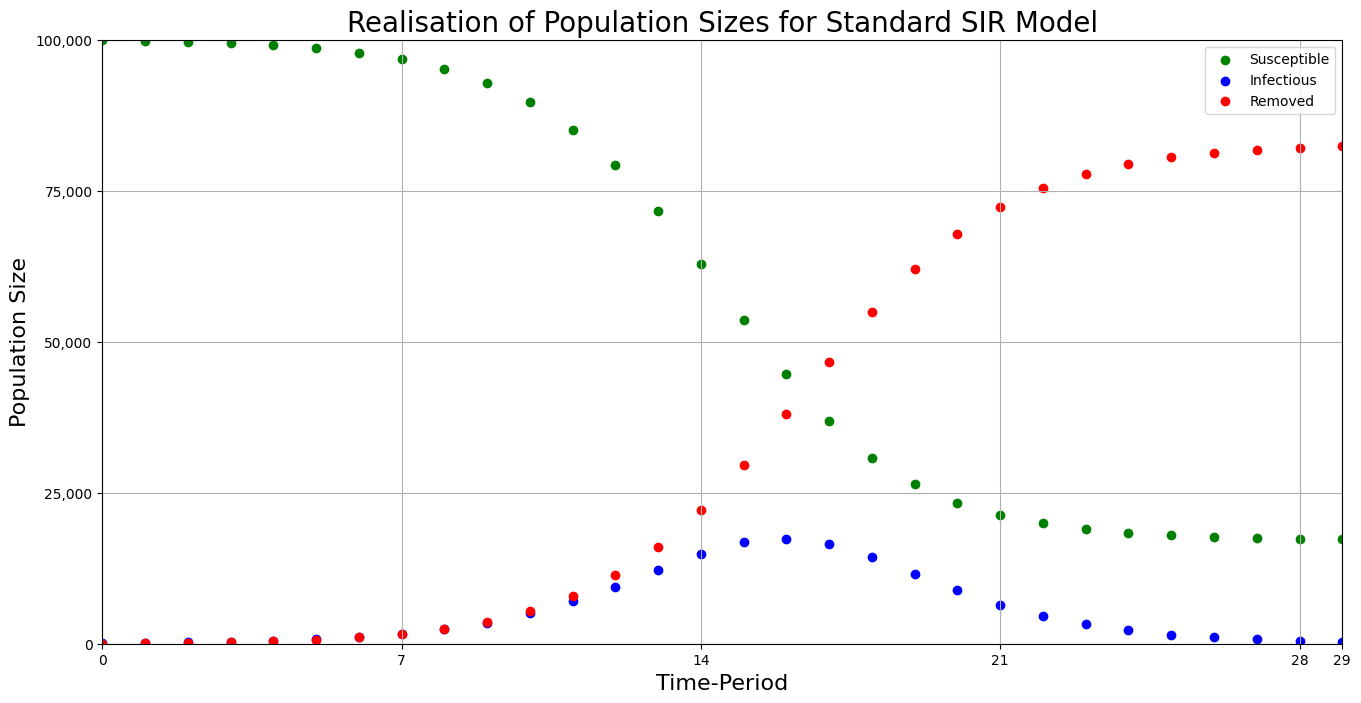

In [6]:
# Model
population_size=100000
initially_infected=100
beta=1
gamma=.5

sm=Models.SIRModel(
    params=[population_size,initially_infected,beta,gamma],
    n_obs=30,
    x_obs=[[x] for x in range(30)]
    )
sm.plot_obs()

### Priors
$$ \pi_0(\beta)\sim\text{Uniform}[0,2.5] $$
$$ \pi_0(\gamma)\sim\text{Uniform}[0,0.8] $$

Due to implementation choices, priors need to be defined for the population size and initial number of infectees, but these are assumed known so are passed distributions which produce constant values.

In [7]:
# Priors
beta_prior=stats.uniform(0,2.5)
gamma_prior=stats.uniform(0,0.8)

sm_priors=[stats.uniform(100000,0),stats.uniform(100,0),beta_prior,gamma_prior]

### Perturbance Kernels

$$ K^*(X)\sim\text{Normal}(X,0.1^2) $$
Perturbance kernels for ABC-MCMC and ABC-SMC. The kernel specified below applies additive Gaussian noise with $\sigma=0.1$ to $\beta$ and $\gamma$ independently. `perturbance_kernel_probability` provides functions to determine the probability that a purbance kernel produced a given value.

Due to implementation choices, perturbance kernels need to be defined for the population size and initial number of infectees, but these are assumed known so the identity function is used.

In [8]:
perturbance_sd=.1
perturbance_kernels = [lambda x:x]*2 + [lambda x:x+stats.norm(0,perturbance_sd).rvs(1)[0]]*2
perturbance_kernel_probability = [lambda x,y:1]*2 + [lambda x,y:stats.norm(0,perturbance_sd).pdf(x-y)]*2

# ABC-Rejection Sampling
ABC-Rejection Sampling generating samples until 100 have been accepted using log-Euclidean distance measure and Gaussian acceptance kernel with bandwidth $1$.

(20,980) 100/100



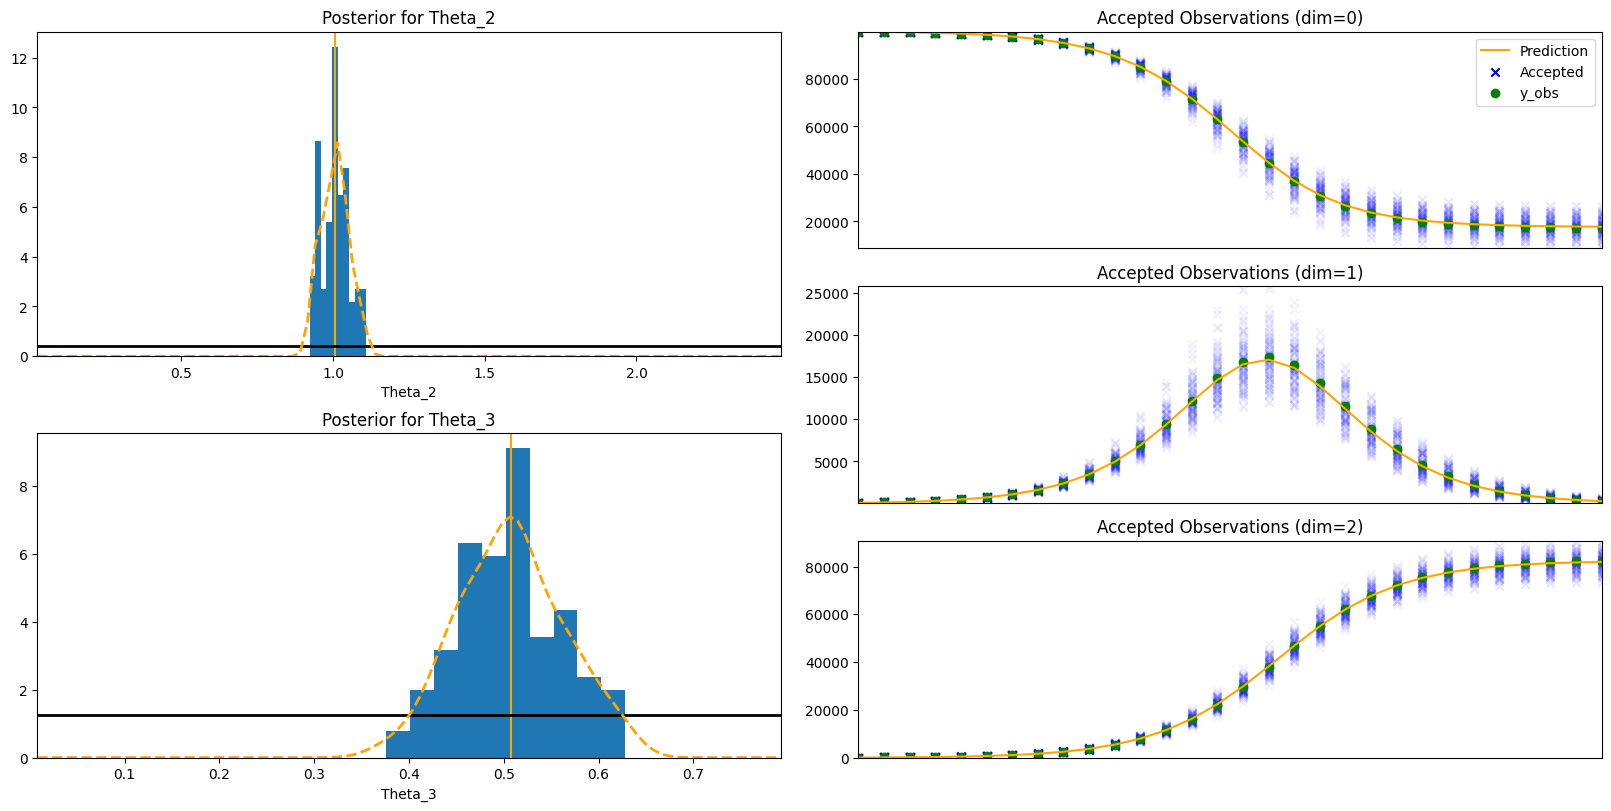

Population Size=100,000.0
Initially Infected=100.0
Beta=1.007
Gamma=0.508
R_0=1.983
Wall time: 41.2 s


In [9]:
%%time
np.random.seed(seed) # Fix random seed

# Details of ABC-Rejection version
sampling_details={
    "sampling_method":"fixed_number",
    "sample_size":100,
    "scaling_factor":1,
    "distance_measure":ABC.log_l2_norm,
    "kernel_func":ABC.gaussian_kernel}

# ABC-Rejection
fitted_model_rs,accepted_params_rs=ABC.abc_rejection(
    n_obs=30,
    y_obs=sm.observe(),
    fitting_model=sm.copy([1,1,1,1]),
    priors=sm_priors,
    sampling_details=sampling_details,
    summary_stats=None, # Use identity function
    show_plots=True,
    printing=True
)

print(fitted_model_rs)

*Note* - $\beta=$ `Theta_2`, $\gamma=$`Theta_3`, Susceptible=dim 0, Infectious=dim 1 and Removed=dim 2.

**Results** - Posterior means are $\hat\beta=1.007$ and $\hat\gamma=0.508$. Took 20,980 simulations until 100 were accepted.

<Figure size 1600x800 with 0 Axes>

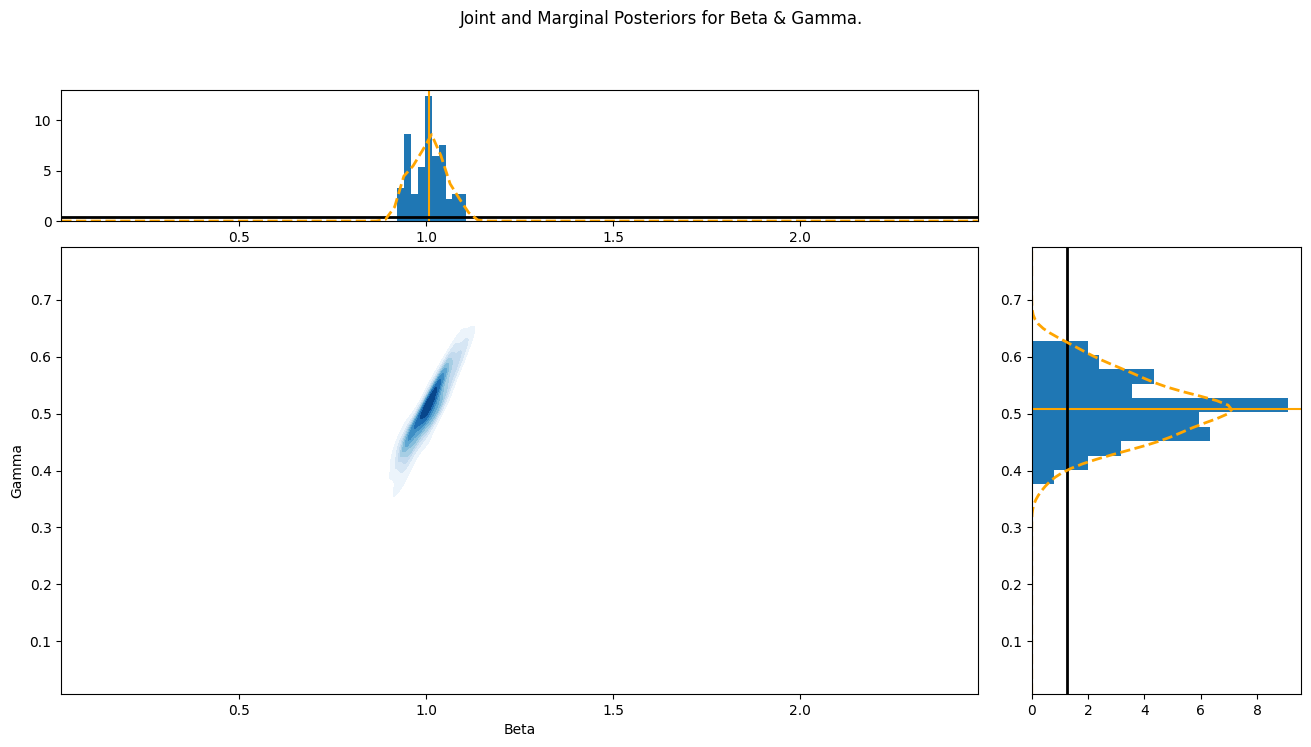

In [10]:
fig=plt.figure()

ax=Plotting.plot_joint_parameter_posteriors(
    fig,
    parameter_names=["Beta","Gamma"],
    accepted_parameters=[p[2:] for p in accepted_params_rs], # only beta and gamma values
    predicted_vals=fitted_model_rs.params[2:],
    priors=sm_priors[2:],
    weights=None
)

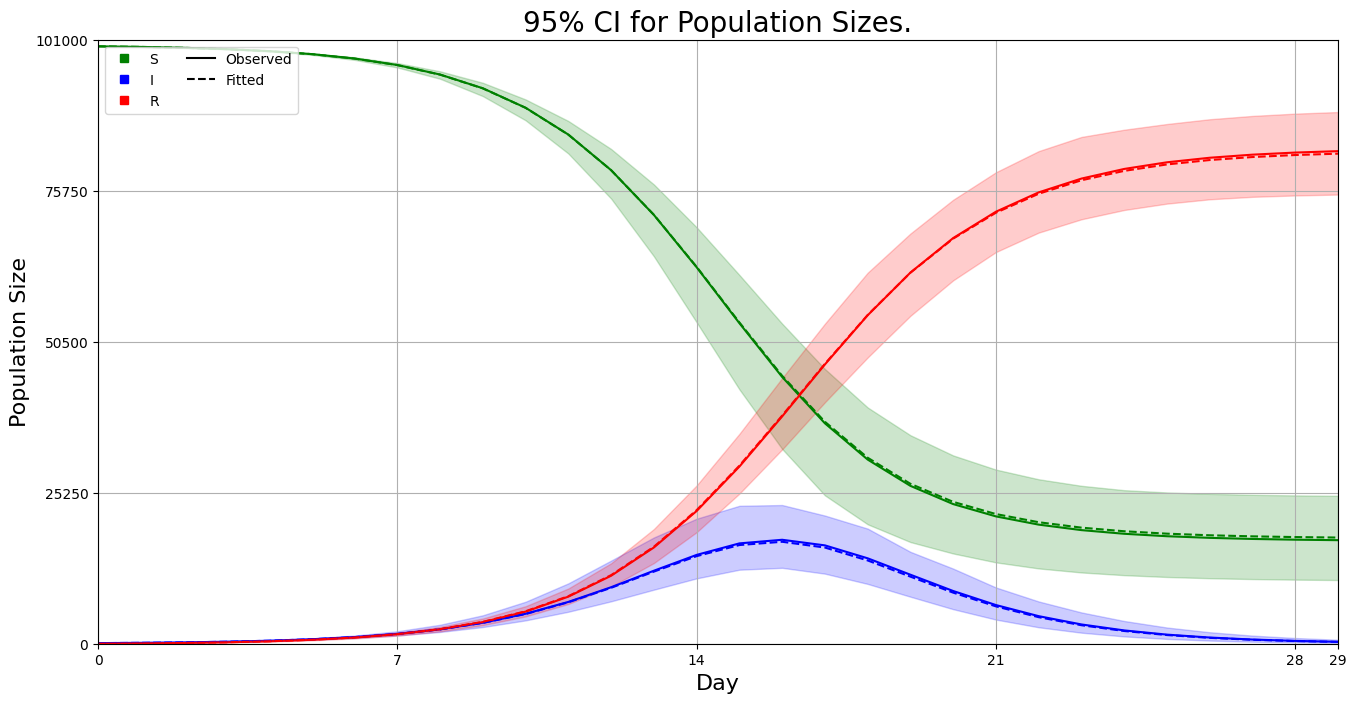

In [11]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)

ax=Plotting.plot_sir_model_ci(ax,x_obs=sm.x_obs,y_obs=sm.observe(),predicted_model=fitted_model_rs,accepted_params=accepted_params_rs,weights=None,alpha=0.05,legend=True)

# "Best Samples" ABC-Rejection Sampling
"Best Samples" flavour of ABC-Rejection generating 20,000 simulations and accepting the closetst 50 using the log-Euclidean norm as the distance measure and identity function as the summary statistic.

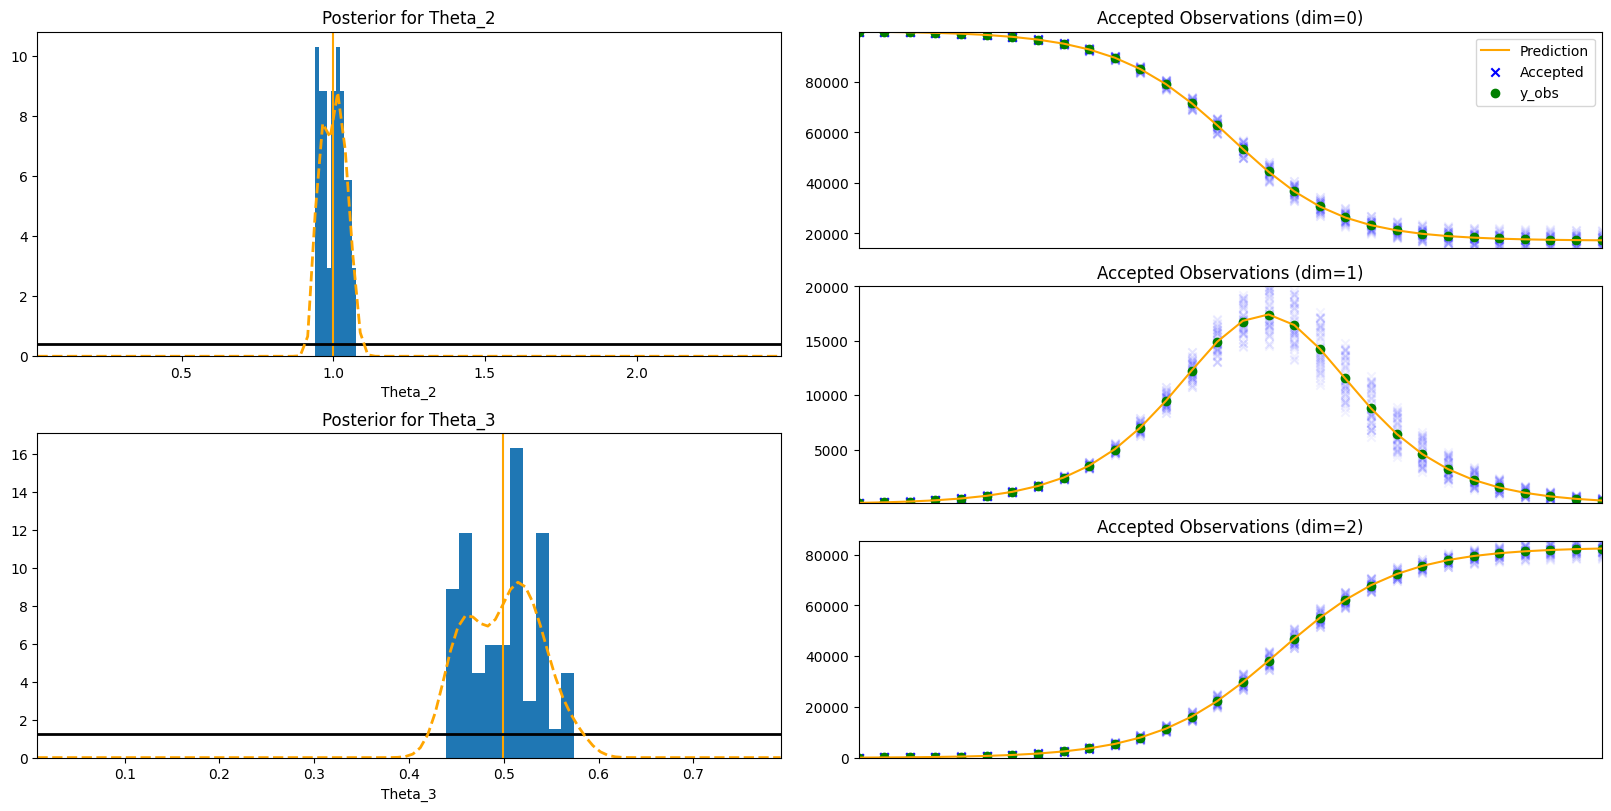

Population Size=100,000.0
Initially Infected=100.0
Beta=1.000
Gamma=0.500
R_0=2.002
Wall time: 20.5 s


In [12]:
%%time
np.random.seed(seed) # Fix random seed

# Details of ABC-Rejection version
sampling_details={
    "sampling_method":"best",
    "num_runs":20000, # num simulations to generate
    "sample_size":50, # num simulations to keep
    "distance_measure":ABC.l2_norm}

# ABC-Rejection
fitted_model_best_rs,accepted_params_best_rs=ABC.abc_rejection(
    n_obs=30,
    y_obs=sm.observe(),
    fitting_model=sm.copy([1,1,1,1]),
    priors=sm_priors,
    sampling_details=sampling_details,
    summary_stats=None, # Use identity function
    show_plots=True,
    printing=True
)

print(fitted_model_best_rs)

*Note* - $\beta=$ `Theta_2`, $\gamma=$`Theta_3`, Susceptible=dim 0, Infectious=dim 1 and Removed=dim 2.

**Results** - Posterior means are $\hat\beta=1.000$ and $\hat\gamma=0.500$.

<Figure size 1600x800 with 0 Axes>

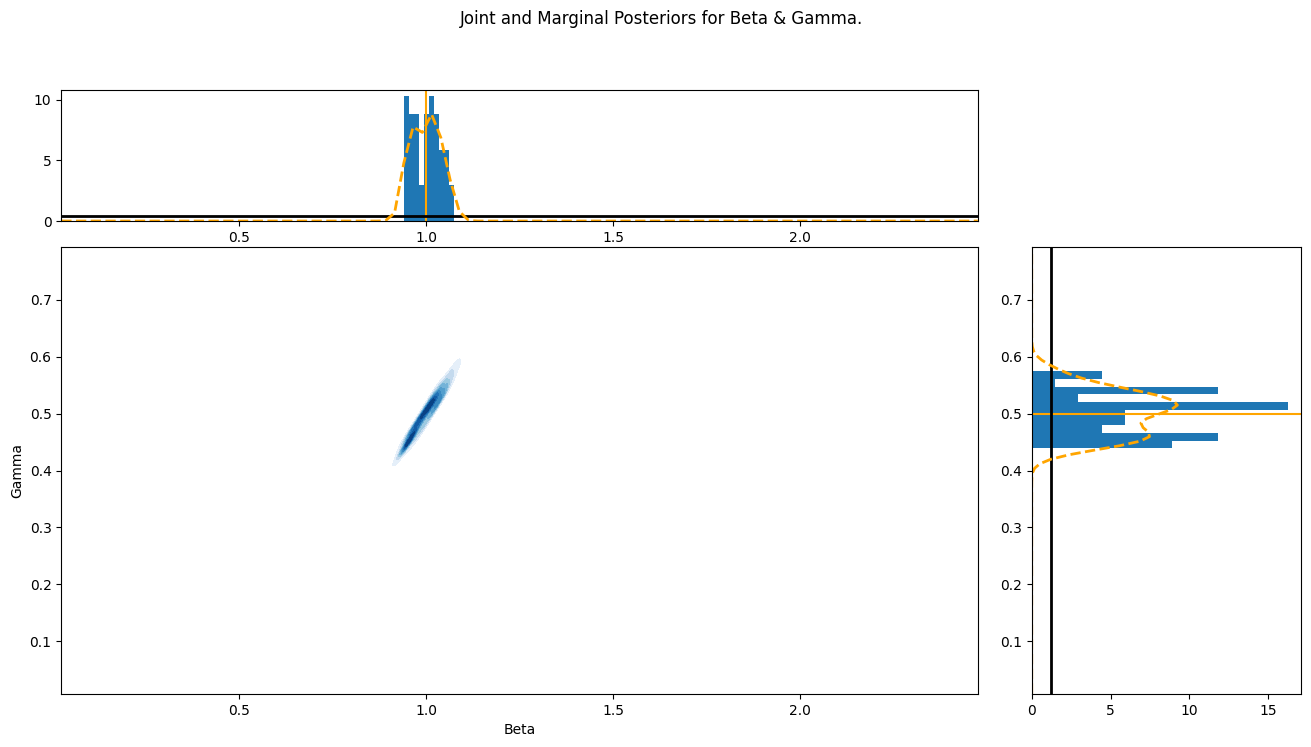

In [13]:
fig=plt.figure()

ax=Plotting.plot_joint_parameter_posteriors(
    fig,
    parameter_names=["Beta","Gamma"],
    accepted_parameters=[p[2:] for p in accepted_params_best_rs], # only beta and gamma values
    predicted_vals=fitted_model_best_rs.params[2:],
    priors=sm_priors[2:],
    weights=None
)

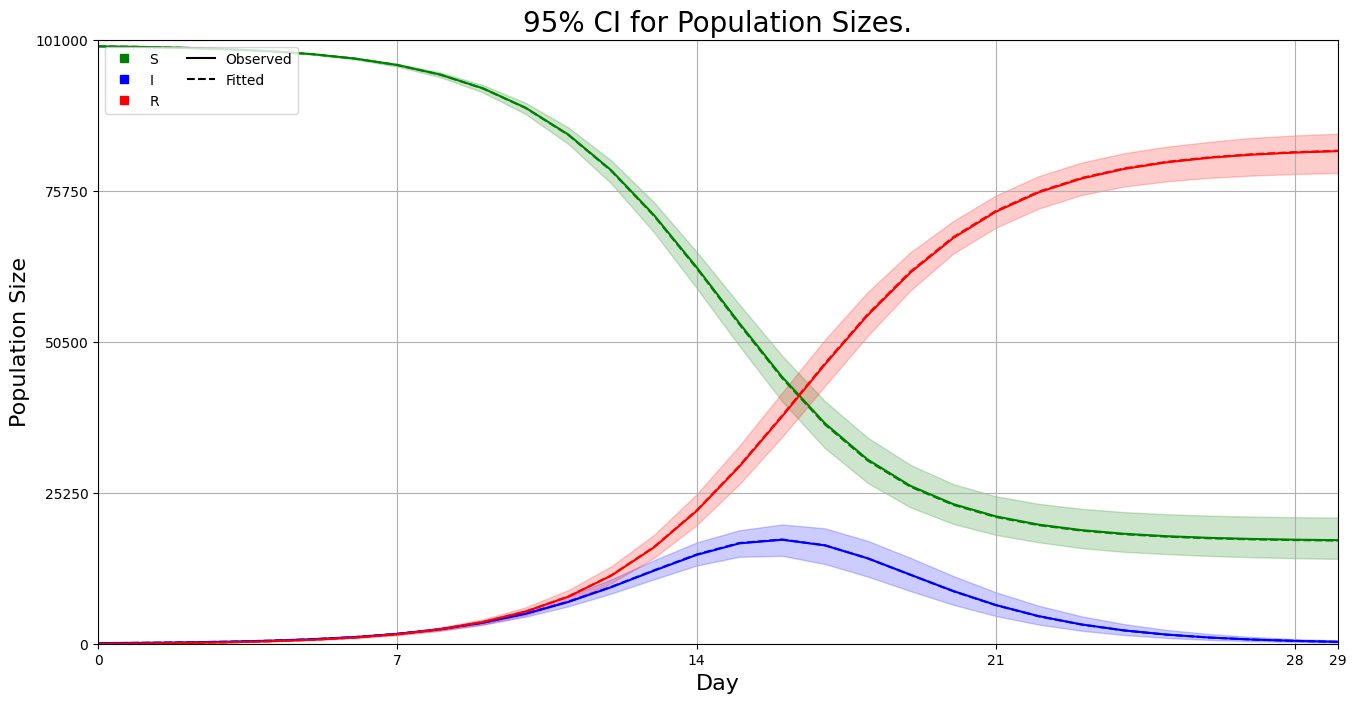

In [14]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)

ax=Plotting.plot_sir_model_ci(ax,x_obs=sm.x_obs,y_obs=sm.observe(),predicted_model=fitted_model_best_rs,accepted_params=accepted_params_best_rs,weights=None,alpha=0.05,legend=True)

# ABC-MCMC
ABC-MCMC using the identity function as its summary statistic, log-Euclidean norm as distance measure and a Gaussian Kernel with bandwidth $10^{-2/5}$. Runs for a chain-length of 20,000 after initial burn in. Uses additive Gaussian noise perturbance kernels defined [above](#Perturbance-Kernels).

Found Start - (25) [100000.0, 100.0, 0.955665396986747, 0.465480716947413]
0.240 observations were new.


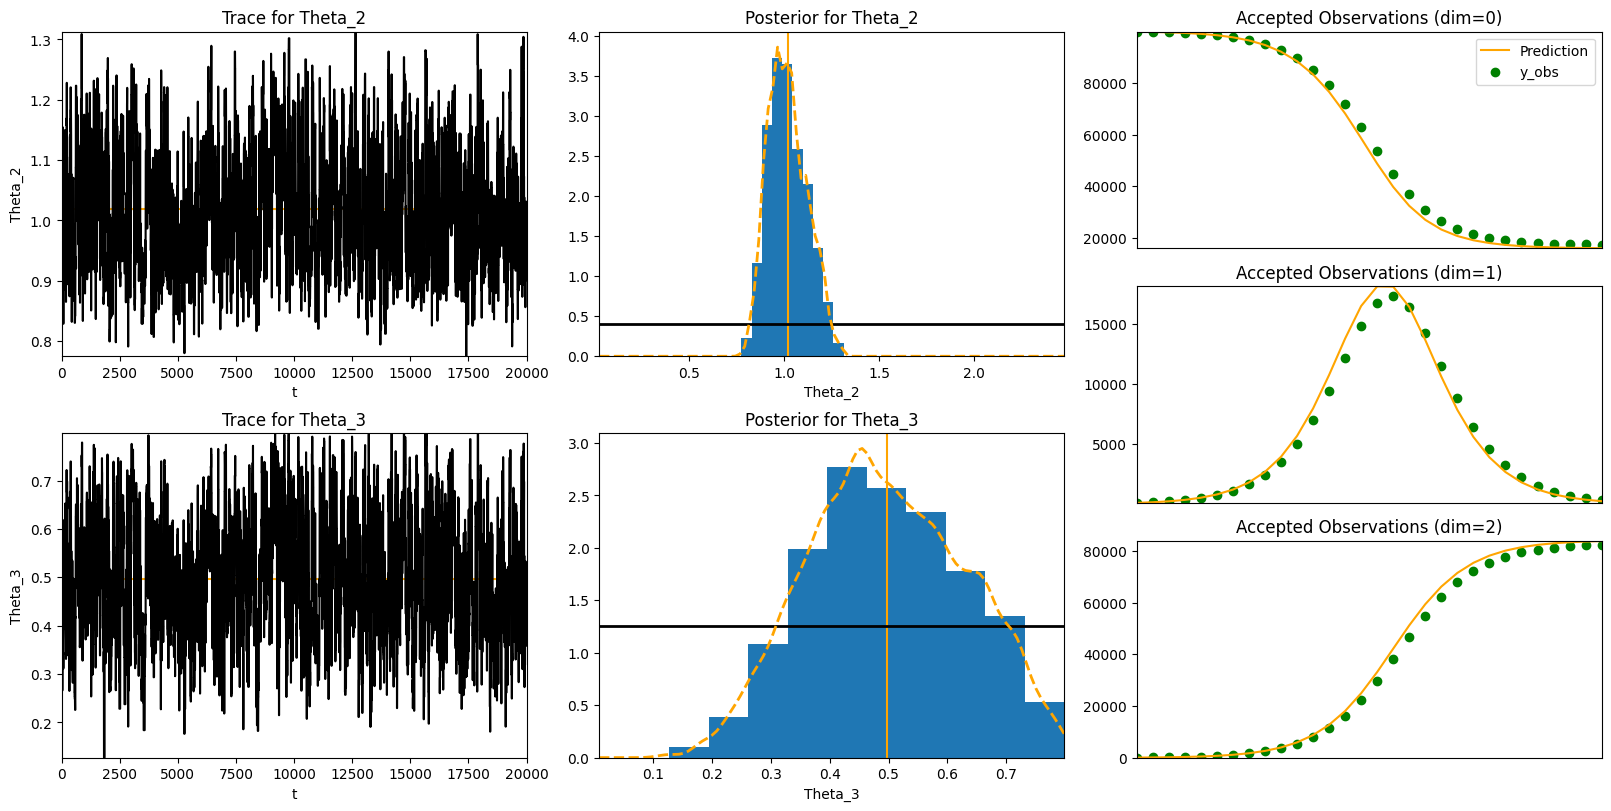

Population Size=100,000.0
Initially Infected=100.0
Beta=1.018
Gamma=0.497
R_0=2.047
Wall time: 1min 27s


In [15]:
%%time
np.random.seed(seed) # Fix random seed

fitted_model_mcmc,accepted_params_mcmc=ABC.abc_mcmc(
    n_obs=30,
    y_obs=sm.observe(),
    fitting_model=sm.copy([1,1,1,1]),
    priors=sm_priors,
    chain_length=20000,
    perturbance_kernels=perturbance_kernels,
    acceptance_kernel=ABC.gaussian_kernel,
    scaling_factor=10**(-.4),
    summary_stats=None,
    distance_measure=ABC.log_l2_norm,
    show_plots=True,
    printing=True
)

print(fitted_model_mcmc)

*Note* - $\beta=$ `Theta_2`, $\gamma=$`Theta_3`, Susceptible=dim 0, Infectious=dim 1 and Removed=dim 2.

**Results** - Posterior means are $\hat\beta=1,018$ and $\hat\gamma=0.497$. Burn in took 25 iterations and acceptance rate was $24.0\%$.

<Figure size 1600x800 with 0 Axes>

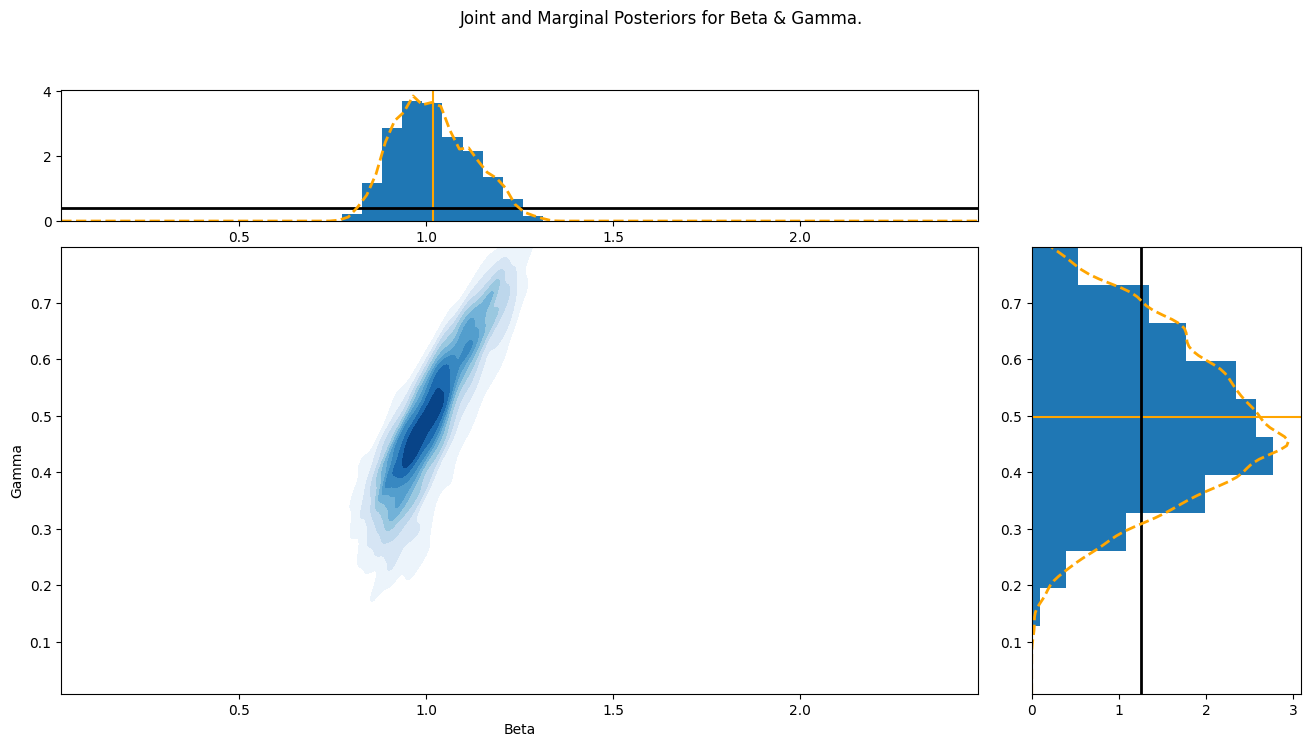

In [16]:
fig=plt.figure()

ax=Plotting.plot_joint_parameter_posteriors(
    fig,
    parameter_names=["Beta","Gamma"],
    accepted_parameters=[p[2:] for p in accepted_params_mcmc], # only beta and gamma values
    predicted_vals=fitted_model_mcmc.params[2:],
    priors=sm_priors[2:],
    weights=None
)

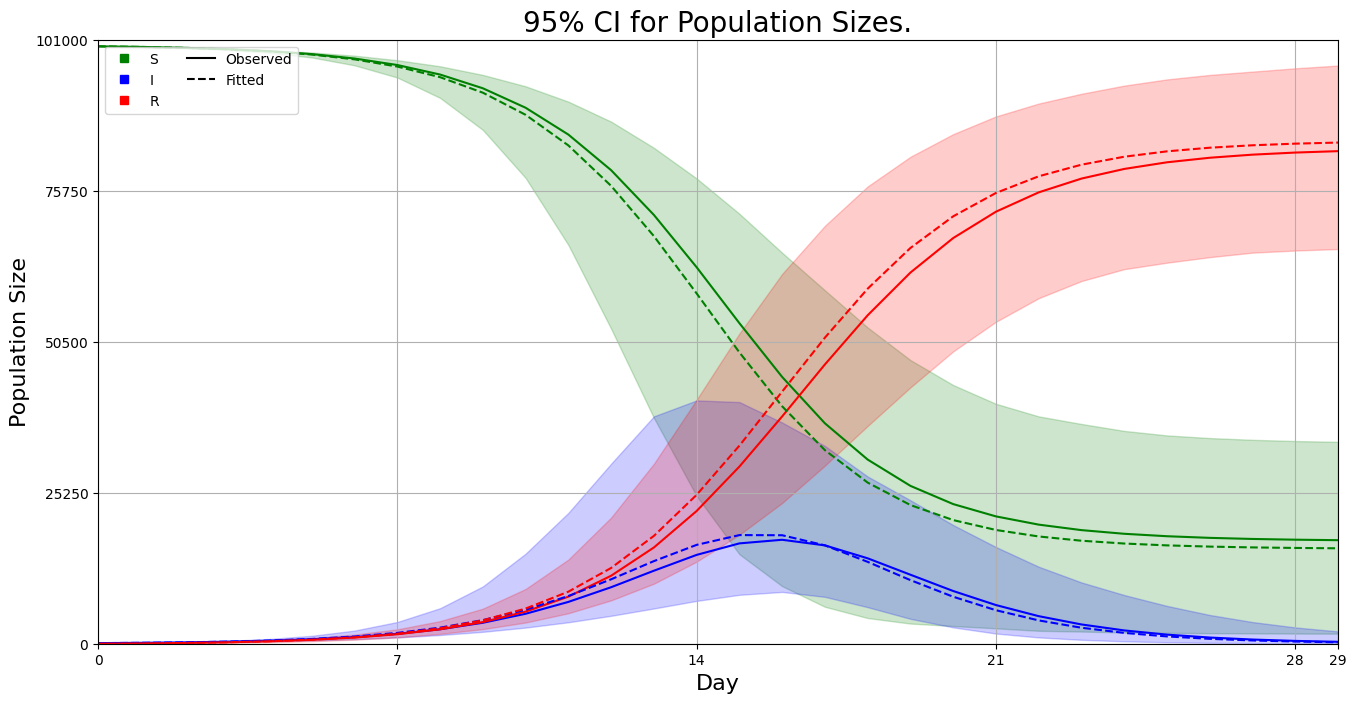

In [17]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)

ax=Plotting.plot_sir_model_ci(ax,x_obs=sm.x_obs,y_obs=sm.observe(),predicted_model=fitted_model_mcmc,accepted_params=accepted_params_mcmc,weights=None,alpha=0.05,legend=True)

# ABC-SMC
ABC-SMC keeping a sample of size 100 using the identity function as its summary statistic, log-Euclidean norm as distance measure and a Gaussian Kernel with a set of 20 bandwidths stepped from $10^{-2}$ to $10^{-1}$.

In [18]:
# due to implementation
sm_priors_smc=[stats.uniform(100000,.01),stats.uniform(100,.01),beta_prior,gamma_prior]

In [19]:
# list of tightening bandwidths
scaling_factors=list(np.logspace(-2,-.1,20,base=10))

(108) - 100/100
(1/20 - 107) - 99/100 (eps=0.013)
(2/20 - 107) - 99/100 (eps=0.016)
(3/20 - 113) - 99/100 (eps=0.020)
(4/20 - 117) - 99/100 (eps=0.025)
(5/20 - 124) - 99/100 (eps=0.032)
(6/20 - 132) - 99/100 (eps=0.040)
(7/20 - 137) - 99/100 (eps=0.050)
(8/20 - 162) - 99/100 (eps=0.063)
(9/20 - 193) - 99/100 (eps=0.079)
(10/20 - 183) - 99/100 (eps=0.100)
(11/20 - 205) - 99/100 (eps=0.126)
(12/20 - 283) - 99/100 (eps=0.158)
(13/20 - 283) - 99/100 (eps=0.200)
(14/20 - 263) - 99/100 (eps=0.251)
(15/20 - 388) - 99/100 (eps=0.316)
(16/20 - 459) - 99/100 (eps=0.398)
(17/20 - 581) - 99/100 (eps=0.501)
(18/20 - 904) - 99/100 (eps=0.631)
(19/20 - 1,075) - 99/100 (eps=0.794)

Total Simulations - 5,924
theta_hat - [100000.0057215185, 100.00664001343418, 1.0012430765068459, 0.4948494994479122]


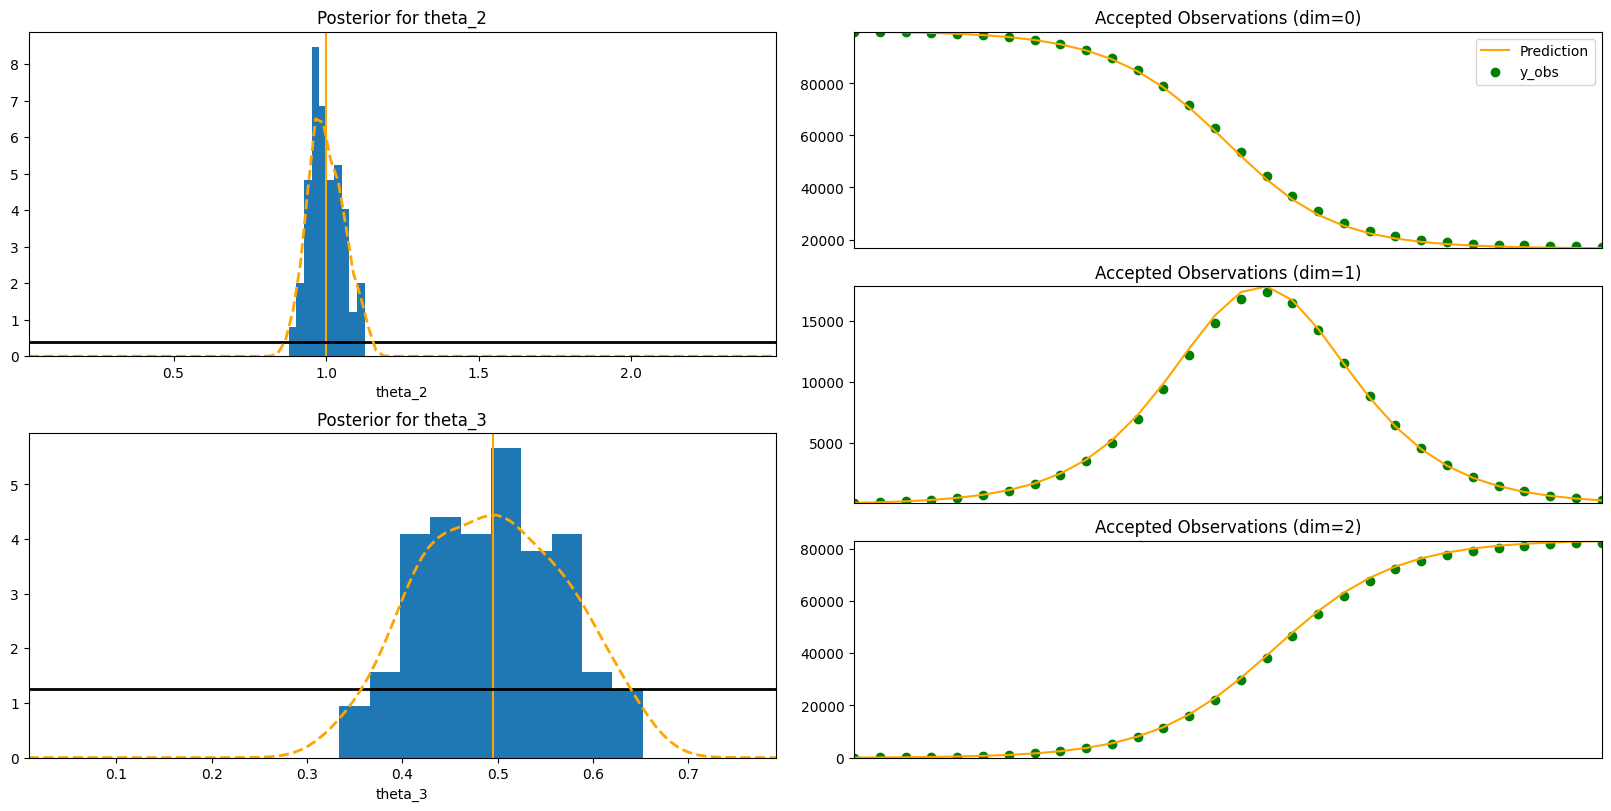

Population Size=100,000.0
Initially Infected=100.0
Beta=1.001
Gamma=0.495
R_0=2.023
Wall time: 6min 35s


In [20]:
%%time
np.random.seed(seed) # Fix random seed

fitted_model_smc,accepted_params_smc,weights_smc=ABC.abc_smc(
    n_obs=30,
    y_obs=sm.observe(),
    fitting_model=sm.copy([1,1,1,1]),
    priors=sm_priors_smc,
    num_steps=20,
    sample_size=100,
    scaling_factors=scaling_factors,
    acceptance_kernel=ABC.gaussian_kernel,
    adaptive_perturbance=False,
    perturbance_kernels=perturbance_kernels,
    perturbance_kernel_probability=perturbance_kernel_probability,
    summary_stats=None,
    distance_measure=ABC.log_l2_norm,
    show_plots=True,
    printing=True
)

print(fitted_model_smc)

*Note* - $\beta=$ `Theta_2`, $\gamma=$`Theta_3`, Susceptible=dim 0, Infectious=dim 1 and Removed=dim 2.

**Results** - Posterior means are $\hat\beta=1.001$ and $\hat\gamma=0.495$. A total of 5,924 simulations were performed

<Figure size 1600x800 with 0 Axes>

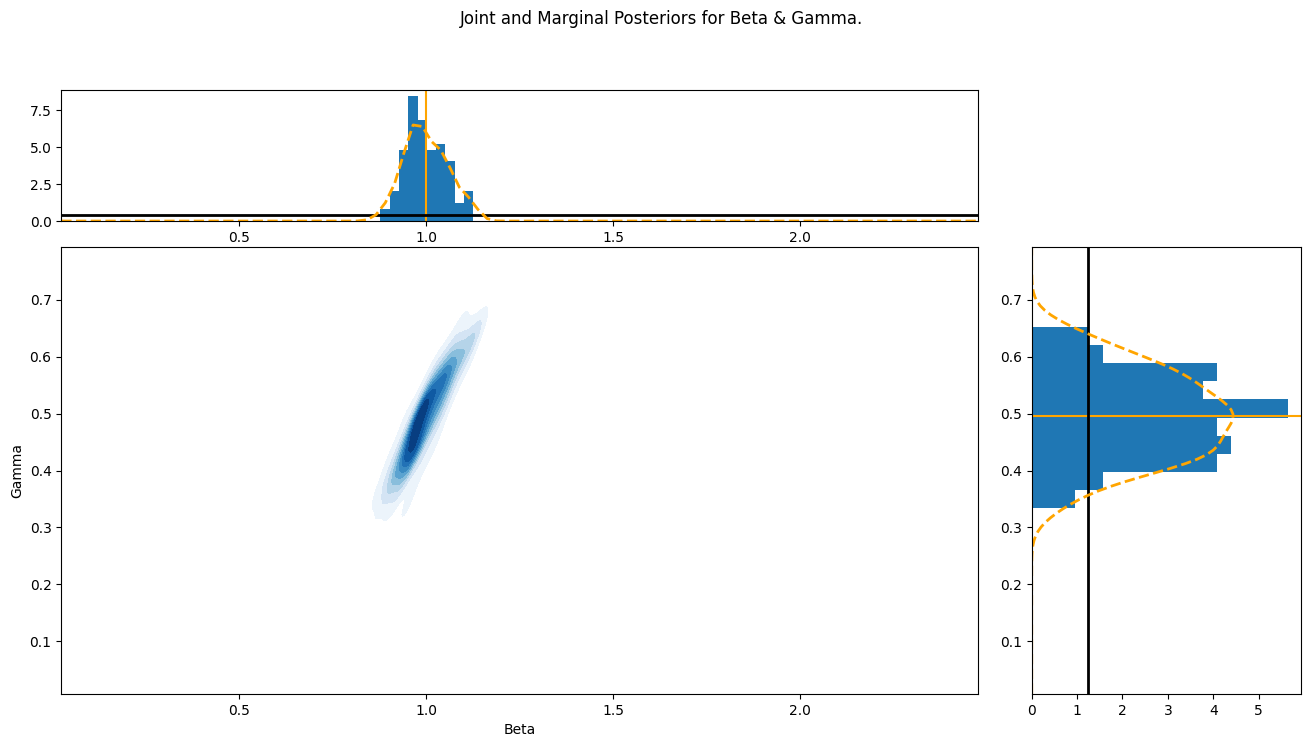

In [21]:
fig=plt.figure()

ax=Plotting.plot_joint_parameter_posteriors(
    fig,
    parameter_names=["Beta","Gamma"],
    accepted_parameters=[p[2:] for p in accepted_params_smc], # only beta and gamma values
    predicted_vals=fitted_model_smc.params[2:],
    priors=sm_priors_smc[2:],
    weights=weights_smc
)

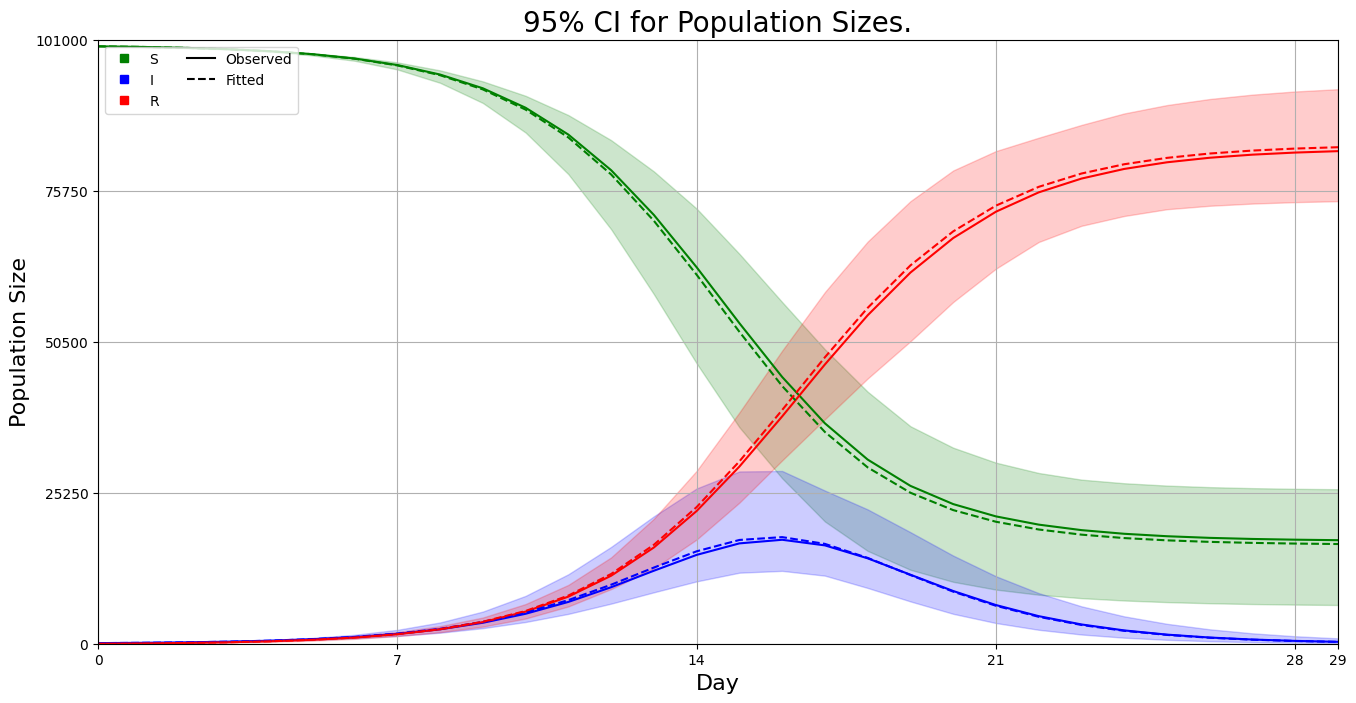

In [22]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)

ax=Plotting.plot_sir_model_ci(ax,x_obs=sm.x_obs,y_obs=sm.observe(),predicted_model=fitted_model_smc,accepted_params=accepted_params_smc,weights=weights_smc,alpha=0.05,legend=True)

# Adaptive ABC-SMC

Adaptive ABC-SMC maintain a sample of size 100 with the identity function as its summary statistic, log-Euclidean norm as distance measure and a uniform kernel. The target acceptance rate is $\alpha=-.9$.

In [ ]:
%%time
np.random.seed(seed) # Fix random seed

fitted_model_adapt_smc,accepted_params_adapt_smc,weights_adapt_smc=ABC.adaptive_abc_smc(
    n_obs=30,
    y_obs=sm.observe(),
    fitting_model=sm.copy([1,1,1,1]),
    priors=sm_priors_smc,
    max_steps=100,
    sample_size=100,
    acceptance_kernel=ABC.uniform_kernel,
    alpha=.9,
    initial_scaling_factor=30,
    terminal_scaling_factor=0,
    max_simulations=2500,
    summary_stats=None,
    distance_measure=ABC.log_l2_norm,
    show_plots=True,
    printing=True
)
print(fitted_model_adapt_smc)

In [ ]:
fig=plt.figure()

ax=Plotting.plot_joint_parameter_posteriors(
    fig,
    parameter_names=["Beta","Gamma"],
    accepted_parameters=[p[2:] for p in accepted_params_adapt_smc], # only beta and gamma values
    predicted_vals=fitted_model_adapt_smc.params[2:],
    priors=sm_priors_smc[2:],
    weights=weights_smc
)

In [ ]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)

ax=Plotting.plot_sir_model_ci(ax,x_obs=sm.x_obs,y_obs=sm.observe(),predicted_model=fitted_model_adapt_smc,accepted_params=accepted_params_adapt_smc,weights=weights_adapt_smc,alpha=0.05,legend=True)